<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the essentials

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import os

project_dir = "/content/drive/MyDrive/DR_Project"
if os.path.exists(project_dir):
    print("Directory exists:", project_dir)
else:
    print("Directory not found. Creating it...")
    os.makedirs(project_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory exists: /content/drive/MyDrive/DR_Project


In [7]:
%cd /content/drive/MyDrive/4 idots project
!ls

/content/drive/MyDrive/4 idots project


In [12]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm.notebook import tqdm

import os

# Correct the path
base_dir = "/content/drive/MyDrive/DR_Project/input"
print(os.listdir(base_dir))

# If needed, access subdirectories
train_images_path = os.path.join(base_dir, "train_images")
test_images_path = os.path.join(base_dir, "test_images")

# Verify the contents
print("Train Images:", os.listdir(train_images_path))
print("Test Images:", os.listdir(test_images_path))


['test.csv', 'sample_submission.csv', 'train.csv', 'test_images', 'train_images']
Train Images: ['b835b6e31a59.png', 'b77b8a1f09f1.png', 'b7bd4a6627b6.png', 'b9127e38d9b9.png', 'b8f1b30877db.png', 'b82dfa63a75f.png', 'b8fb9f55cd6d.png', 'b7983cb3f270.png', 'b927a9238434.png', 'b7ce561a7328.png', 'b77b88926843.png', 'b86fb2d5be1a.png', 'b82d5f1f1145.png', 'b762c29cf2f3.png', 'ba4d2c4b3039.png', 'bacfb1029f6b.png', 'b98f77098b9d.png', 'ba08cee68c71.png', 'b99c825b93c5.png', 'ba2ea9182090.png', 'bb08949dd70a.png', 'ba2624883599.png', 'bb45257258cc.png', 'b95d4dd8e5e2.png', 'b9519abce0c1.png', 'b9b99dad668d.png', 'b9bc81fcb075.png', 'ba0107fb1bfd.png', 'baaca2f7e1f0.png', 'bacfa2b8e706.png', 'b96b518596b3.png', 'b9d0b83d70c3.png', 'bab776139279.png', 'b960142a8de7.png', 'b963a11638f2.png', 'ba25f947f4ec.png', 'b9b6ee2b9453.png', 'b9fe7da14a32.png', 'bac1744955c2.png', 'ba735b286d62.png', 'b99794a0beed.png', 'bb2f89488ecd.png', 'b9c7c5182075.png', 'ba4e62c11cc0.png', 'badb5ff8d3c7.png', 'b9

In [14]:
!pip install scikit-image


In [13]:
print(os.listdir("/content/drive/MyDrive/DR_Project/input"))

['test.csv', 'sample_submission.csv', 'train.csv', 'test_images', 'train_images']


In [15]:
import seaborn as sns

# Loading Data + EDA

In [16]:
import pandas as pd

# Corrected paths for Google Drive
base_dir = '/content/drive/MyDrive/DR_Project/input'
train_csv_path = f'{base_dir}/train.csv'
test_csv_path = f'{base_dir}/test.csv'

# Load the CSV files
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

# Verify that the data has been loaded correctly
print("Training Data:")
print(train_csv.head())
print("\nTesting Data:")
print(test_csv.head())


Training Data:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Testing Data:
        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


In [17]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [18]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<ipython-input-19-7b36665902b2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')


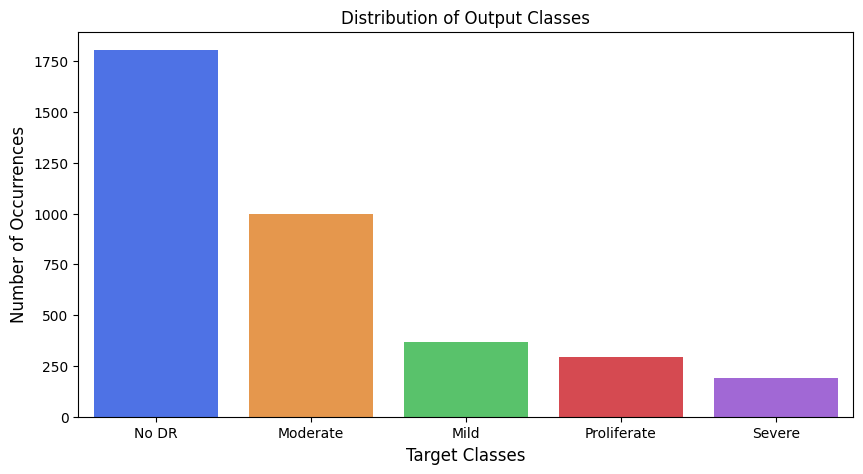

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get counts for each diagnosis class
counts = train_csv['diagnosis'].value_counts()

# Map class labels
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
counts.index = [class_list[int(i)] for i in counts.index]

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()


# Visualizing Training Data

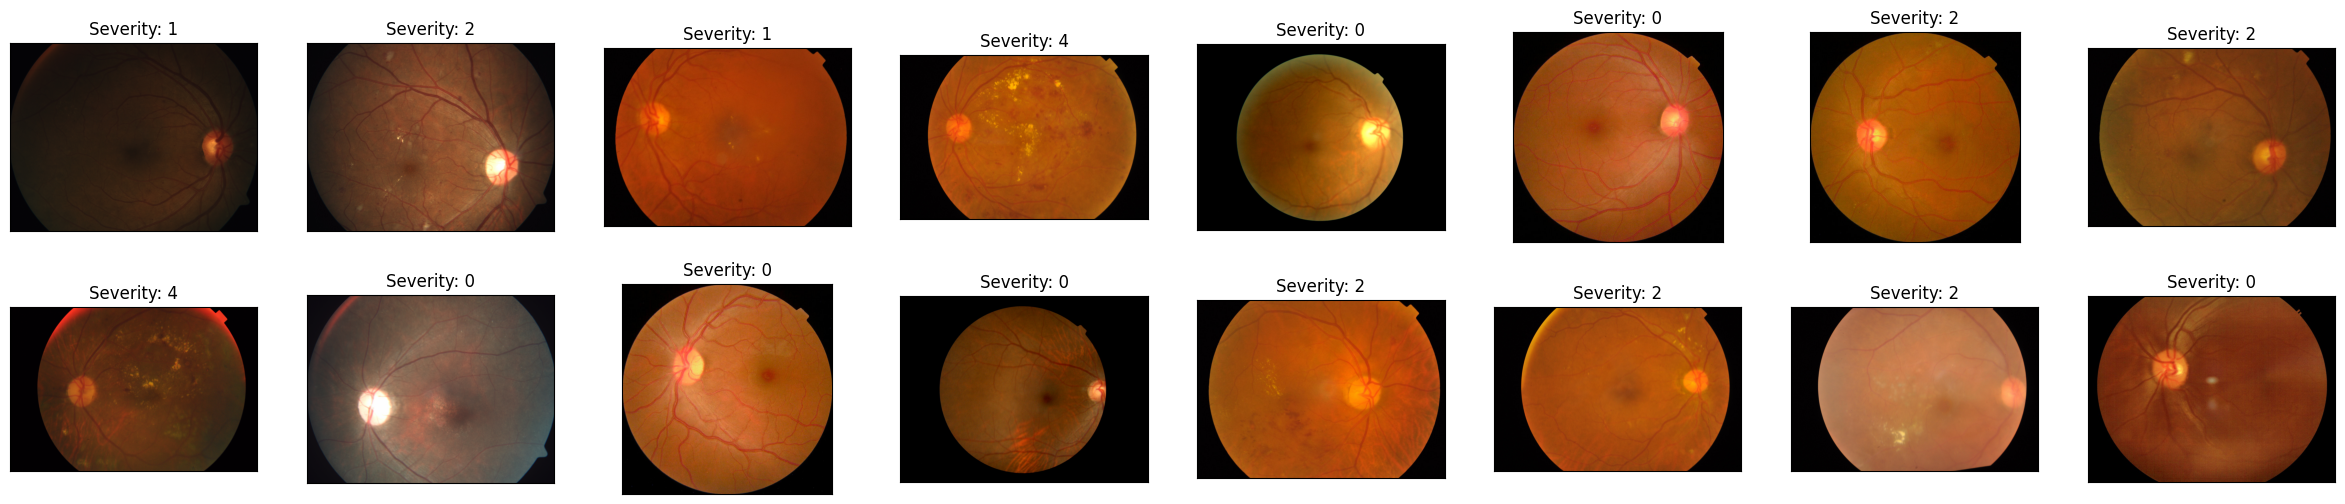

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(base_dir + "/train_images")

for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 8, idx + 1, xticks=[], yticks=[])
    im = Image.open(base_dir + "/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title(f'Severity: {lab}')


# Visualizing Test Set

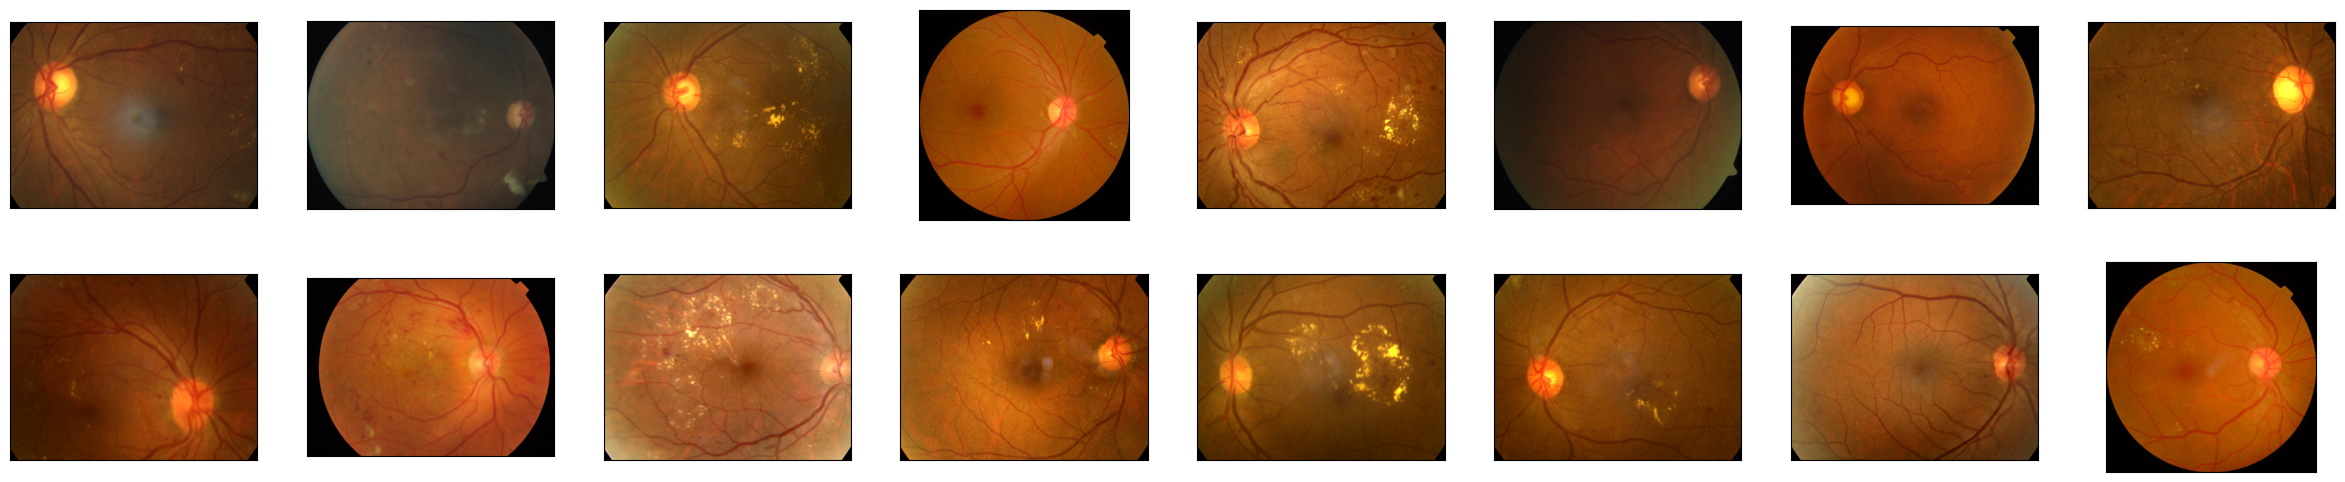

In [21]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

# Data Processing

In [ ]:
import os
import cv2
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='/content/drive/MyDrive/DR_Project/input/train_images', transform=None):
        super().__init__()
        self.df = df_data  # must be a DataFrame
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index]['id_code']
        label = self.df.iloc[index]['diagnosis']

        img_path = os.path.join(self.data_dir, img_name + '.png')

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Convert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [23]:
from torchvision import transforms


In [24]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [25]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [26]:
train_path = "/content/drive/MyDrive/DR_Project/input/train_images/"
test_path = "/content/drive/MyDrive/DR_Project/input/test_images/"


In [ ]:
#train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
#test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)


In [27]:
from torch.utils.data import DataLoader


In [28]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class weights section (just after train_csv is loaded and cleaned)
y_train = train_csv['diagnosis'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Dataset creation
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model
import torchvision.models as models
import torch.nn as nn

model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 output classes for DR
model = model.to(device)

# Loss Function (with class weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 128MB/s]


In [29]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [30]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [31]:
from torch.utils.data import DataLoader

# ✅ Updated DataLoaders with performance optimization
trainloader = DataLoader(train_data, batch_size=64, sampler=train_sampler, num_workers=2, pin_memory=True)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler, num_workers=2, pin_memory=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [32]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 1928
46
12
31


In [33]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([2, 0, 2, 4, 0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2,
        4, 0, 4, 0, 0, 3, 4, 0, 1, 3, 2, 0, 4, 0, 0, 2, 0, 2, 0, 1, 0, 0, 2, 0,
        2, 2, 0, 2, 0, 0, 1, 0, 3, 0, 0, 4, 0, 4, 2, 2])


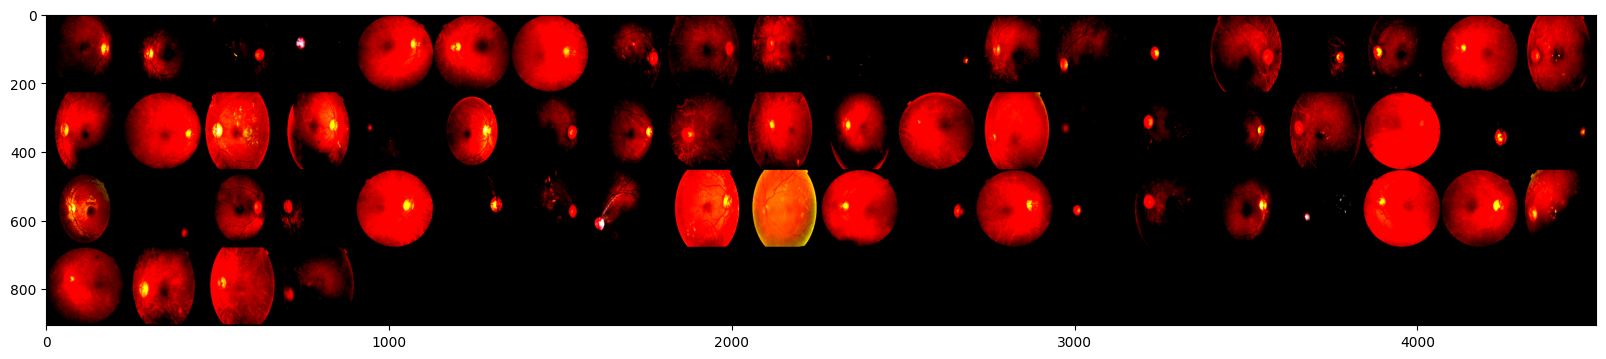

In [34]:
# plotting the images of loaded batch with given fig size and frame data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print('labels:', labels)

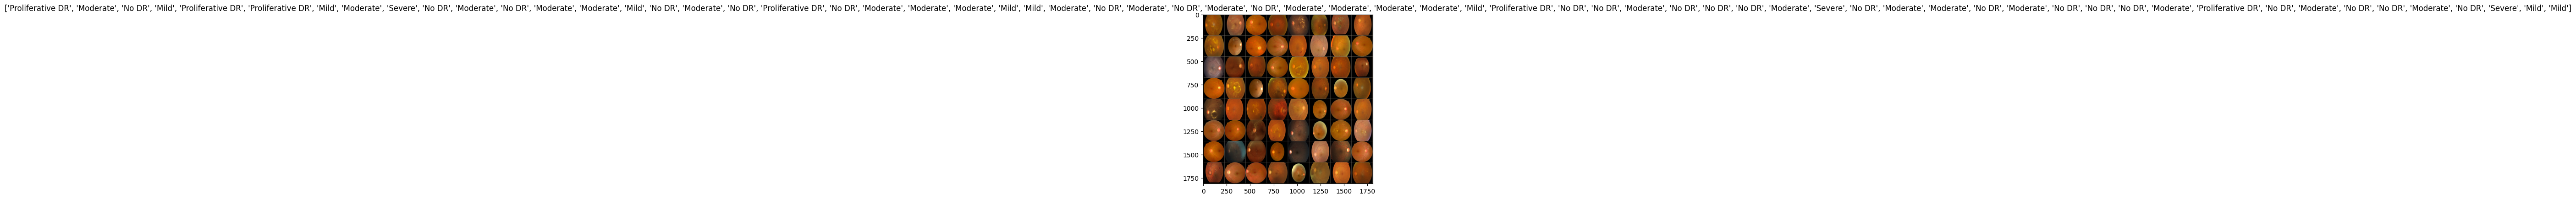

In [35]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [36]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features
out_ftrs = 5

model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [38]:
# Define the model file name
model_save_name = 'classifier.pt'

# Set a valid path for saving the model locally
path = os.path.join("/content/drive/MyDrive/DR_Project/model", model_save_name)

# Ensure the 'models' directory exists
os.makedirs("models", exist_ok=True)

# Example: Saving the model
# torch.save(model.state_dict(), path)

# Example: Loading the model
# model.load_state_dict(torch.load(path))

print(f"Model save/load path: {path}")

Model save/load path: /content/drive/MyDrive/4 idots project/model/classifier.pt


In [39]:
# to unfreeze more layers
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [40]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [41]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [42]:
import torch

# Define the path to the model file
model_path = "/content/drive/MyDrive/DR_Project/models/classifier.pt"

# Load the model with CPU mapping
try:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded successfully from {model_path} on CPU.")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Check the path and file.")
except RuntimeError as e:
    print(f"RuntimeError: {e}")


Error: Model file not found at /content/drive/MyDrive/4 idots project/models/classifier.pt. Check the path and file.


In [43]:
torch.save(model.state_dict(), "models/classifier.pt")

model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [45]:
import torch
import numpy as np
from tqdm.notebook import tqdm

# Train and Test Function
def train_and_test(epochs):
    train_losses, test_losses, acc = [], [], []
    valid_loss_min = np.inf  # Initialize min loss as infinity

    model.train()  # Set model to training mode
    print("Model Training started.....")

    for epoch in range(epochs):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero out the gradients
            outputs = model(images)  # Get model outputs
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model parameters

            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch} completed")

        # Validation loop
        test_loss = 0
        accuracy = 0
        with torch.no_grad():  # No gradients needed for validation
            print(f"Validation started for epoch {epoch + 1}")
            model.eval()  # Set model to evaluation mode
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)  # Get model predictions
                test_loss += criterion(logps, labels)  # Compute test loss
                ps = torch.exp(logps)  # Convert log-probs to probabilities
                top_p, top_class = ps.topk(1, dim=1)  # Get top class
                equals = top_class == labels.view(*top_class.shape)  # Check if correct
                accuracy += torch.mean(equals.type(torch.FloatTensor))  # Compute accuracy

        # Append losses and accuracy for tracking
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(validloader))
        acc.append(accuracy)

        scheduler.step()  # Step the learning rate scheduler

        # Print results for this epoch
        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {running_loss / len(trainloader):.3f}, "
              f"Valid Loss: {test_loss / len(validloader):.3f}, "
              f"Valid Accuracy: {accuracy / len(validloader):.3f}")

        model.train()  # Switch back to training mode

        # Save model if validation loss improved
        if test_loss / len(validloader) <= valid_loss_min:
            print(f"Validation loss decreased. Saving model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_loss': test_loss / len(validloader)
            }, path)
            valid_loss_min = test_loss / len(validloader)

    print("Training Completed Successfully!")
    return train_losses, test_losses, acc


In [46]:
import torch
from tqdm.notebook import tqdm

# Resume Training Function
def resume_training(path, additional_epochs=5):
    # Load checkpoint
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Safe scheduler loading
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        print("Warning: No scheduler_state_dict found in checkpoint. Scheduler will start fresh.")

    start_epoch = checkpoint['epoch']
    best_loss = checkpoint.get('best_loss', float('inf'))  # Get best loss from checkpoint

    print(f"✅ Resuming training from epoch {start_epoch + 1}...")

    for epoch in range(start_epoch + 1, start_epoch + 1 + additional_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f"Training Epoch {epoch}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)

        # Validation loop
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(validloader)
        accuracy = 100 * correct / total

        print(f"📈 Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Accuracy = {accuracy:.2f}%")

        # Step scheduler only if available
        if scheduler:
            scheduler.step(test_loss)

        # Save the best model
        if test_loss < best_loss:
            print("💾 Saving better model (test loss improved)...")
            best_loss = test_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_loss': best_loss
            }, path)


In [ ]:
# Path to your saved model checkpoint
checkpoint_path = "/content/drive/MyDrive/DR_Project/model/model_epoch5.pth"  # Update with your path

# Number of additional epochs to train
additional_epochs = 5  # For example, train for 5 more epochs

# Call the resume training function
resume_training(checkpoint_path, additional_epochs)


✅ Resuming training from epoch 60...


Training Epoch 60:   0%|          | 0/46 [00:00<?, ?it/s]

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Suppose these are your predictions and labels (modify as per your batch/testing loop)
# Example:
# y_pred = model outputs after argmax
# y_true = actual labels from dataset

# Sample tensors (replace with your actual data)
y_pred = torch.tensor([0, 2, 1, 3, 2, 1])
y_true = torch.tensor([0, 1, 1, 3, 2, 0])

# Convert to NumPy for sklearn
y_pred_np = y_pred.cpu().numpy()
y_true_np = y_true.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(y_true_np, y_pred_np)
precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.6667
Precision: 0.7500
Recall   : 0.6667
F1 Score : 0.6667


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Make sure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure model is already loaded and moved to the correct device
model.to(device)
model.eval()

def plot_confusion_matrix(model, validloader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in validloader:
            images = images.to(device)
            labels = labels.to(device)  # this line was missing earlier
            output = model(images)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# After training:
plot_confusion_matrix(model, validloader)


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)

In [ ]:
#scaler = GradScaler()  # For mixed precision


In [ ]:
#np.bincount(train_df['diagnosis'])
